In [51]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
# loading the datasets and preprocessing
# loading movies
movies_path = '/content/drive/MyDrive/movielens/raw/ml-100k/u.item'
movies = pd.read_csv(movies_path, sep='|', encoding='ISO-8859-1', header=None)
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
column_names = ['movie_id', 'title', 'release_date', 'video_release_date',
                'IMDb_URL'] + genre_columns
movies.columns = column_names
def concatenate_genres(row):
    genres = [genre for genre in genre_columns if row[genre] == 1]
    return '|'.join(genres)
movies['genres'] = movies.apply(concatenate_genres, axis=1)
movies = movies[['movie_id', 'title', 'genres']]
movies.loc[:, 'movie_id'] = movies.loc[:, 'movie_id'].apply(lambda x: f'movie_{x}')

# loading ratings
ratings_path = '/content/drive/MyDrive/movielens/raw/ml-100k/u.data'
ratings = pd.read_csv(ratings_path, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings = ratings.sort_values(by=['user_id', 'movie_id'])


print("Ratings data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Ratings data shape: (1682, 3)
Ratings data shape: (100000, 4)


In [53]:
movies.head()

,movie_id,title,genres
0,movie_1,Toy Story (1995),Animation|Children|Comedy
1,movie_2,GoldenEye (1995),Action|Adventure|Thriller
2,movie_3,Four Rooms (1995),Thriller
3,movie_4,Get Shorty (1995),Action|Comedy|Drama
4,movie_5,Copycat (1995),Crime|Drama|Thriller


In [54]:
ratings.head()

,user_id,movie_id,rating,timestamp
32236,1,movie_1,5.0,874965758
13542,1,movie_10,3.0,875693118
17672,1,movie_100,5.0,878543541
59055,1,movie_101,2.0,878542845
19699,1,movie_102,2.0,889751736


In [55]:
def get_movie_title_by_id(movieId):
    return list(movies[movies.movie_id == movieId].title)[0]

def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movie_id)[0]

In [56]:
# checking utility functions
print(get_movie_title_by_id('movie_1'))
print(get_movie_id_by_title('Toy Story (1995)'))

Toy Story (1995)
movie_1


In [57]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

rated_movies = ratings[ratings.rating >= min_rating]
movies_grouped_by_users = list(rated_movies.groupby("user_id"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Computing movie rating frequencies",
):
    current_movies = list(group[1]["movie_id"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

Computing movie rating frequencies: 100%|██████████| 928/928 [00:00<00:00, 1583.63it/s]


In [58]:
user_movie_counts = [len(group[1]["movie_id"]) for group in movies_grouped_by_users]
print("Average number of high-rated movies per user:", sum(user_movie_counts) / len(user_movie_counts))

Average number of high-rated movies per user: 22.845905172413794


In [59]:
min_weight = 30
D = math.log(sum(item_frequency.values()))
movies_graph = nx.Graph()
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 174005/174005 [00:00<00:00, 646655.14it/s]


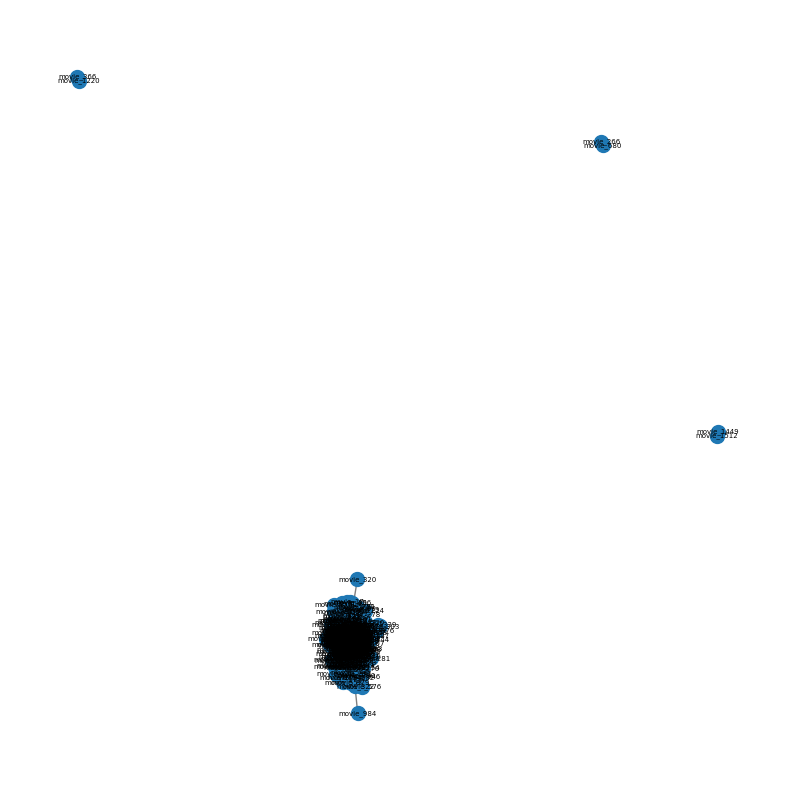

<Figure size 640x480 with 0 Axes>

In [60]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(movies_graph)
nx.draw_networkx_nodes(movies_graph, pos, node_size=100)
nx.draw_networkx_edges(movies_graph, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(movies_graph, pos, font_size=5, font_family="sans-serif")
plt.axis("off")
plt.show()
plt.savefig('ml-100k-graph.png')

In [61]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 516
Total number of graph edges: 15370


In [62]:
degrees = []
for node in movies_graph.nodes:
    degrees.append(movies_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 59.57


In [63]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [64]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    for neighbor in neighbors:
        if neighbor == previous:
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            weights.append(graph[current][neighbor]["weight"])
        else:
            weights.append(graph[current][neighbor]["weight"] / q)
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next

def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)
        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            walk = [node]
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)
    return walks

In [65]:
# walk return param
p = 1
# walk in-out param
q = 1
num_walks = 10
num_steps = 5
walks = random_walk(movies_graph, num_walks, num_steps, p, q)
print("\nNumber of walks generated:", len(walks))

Random walks iteration 10 of 10: 100%|██████████| 516/516 [00:00<00:00, 1084.89it/s]


Number of walks generated: 5160


In [66]:
def skipgram(
    sequence,
    vocabulary_size,
    window_size=4,
    negative_samples=1.0,
    shuffle=True,
    categorical=False,
    sampling_table=None,
    seed=None,
):
    couples = []
    labels = []
    for i, wi in enumerate(sequence):
        if not wi:
            continue
        if sampling_table is not None:
            if sampling_table[wi] < random.random():
                continue

        window_start = max(0, i - window_size)
        window_end = min(len(sequence), i + window_size + 1)
        for j in range(window_start, window_end):
            if j != i:
                wj = sequence[j]
                if not wj:
                    continue
                couples.append([wi, wj])
                if categorical:
                    labels.append([0, 1])
                else:
                    labels.append(1)
    if negative_samples > 0:
        num_negative_samples = int(len(labels) * negative_samples)
        words = [c[0] for c in couples]
        random.shuffle(words)

        couples += [
            [words[i % len(words)], random.randint(1, vocabulary_size - 1)]
            for i in range(num_negative_samples)
        ]
        if categorical:
            labels += [[1, 0]] * num_negative_samples
        else:
            labels += [0] * num_negative_samples
    if shuffle:
        if seed is None:
            seed = random.randint(0, 10e6)
        random.seed(seed)
        random.shuffle(couples)
        random.seed(seed)
        random.shuffle(labels)

    return couples, labels

In [67]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    sample_size = 10
    sample_pairs_labels = []
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        pairs, labels = skipgram(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples)
        if len(sample_pairs_labels) < sample_size:
            sample_indices = random.sample(range(len(pairs)), min(sample_size - len(sample_pairs_labels), len(pairs)))
            sample_pairs_labels.extend([(pairs[i], labels[i]) for i in sample_indices])
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1
    for pair, label in sample_pairs_labels:
        label_type = "Positive" if label == 1 else "Negative"
        print(f"Pair: {pair}, Label: {label} ({label_type})")
    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)
    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)
num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary)
)

Generating postive and negative examples: 100%|██████████| 5160/5160 [00:01<00:00, 3432.45it/s]


Pair: [172, 34], Label: 1 (Positive)
Pair: [172, 22], Label: 0 (Negative)
Pair: [52, 80], Label: 0 (Negative)
Pair: [34, 18], Label: 1 (Positive)
Pair: [34, 213], Label: 0 (Negative)
Pair: [34, 172], Label: 1 (Positive)
Pair: [102, 172], Label: 1 (Positive)
Pair: [34, 59], Label: 0 (Negative)
Pair: [34, 466], Label: 0 (Negative)
Pair: [18, 358], Label: 0 (Negative)


In [68]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")
assert len(targets) == len(contexts) == len(labels), "Lengths of targets, contexts, and labels should be equal"
for i in range(10):
    if labels[i] == 1:
      print("target: ", get_movie_title_by_id(f'movie_{targets[i]}'))
      print("context: ", get_movie_title_by_id(f'movie_{contexts[i]}'))
positive_examples = sum(labels)
negative_examples = len(labels) - positive_examples
print(f"Positive examples: {positive_examples}, Negative examples: {negative_examples}")
unique_pairs = set(zip(targets, contexts))
for i, pair in enumerate(unique_pairs):
    if i > 10: break
    print(f"Pair: {pair}, Weight: {weights[(targets == pair[0]) & (contexts == pair[1])].sum()}")

Targets shape: (136181,)
Contexts shape: (136181,)
Labels shape: (136181,)
Weights shape: (136181,)
target:  White Balloon, The (1995)
context:  Aristocats, The (1970)
Positive examples: 25278, Negative examples: 110903
Pair: (132, 268), Weight: 3
Pair: (244, 509), Weight: 1
Pair: (192, 319), Weight: 5
Pair: (285, 510), Weight: 2
Pair: (155, 437), Weight: 5
Pair: (394, 453), Weight: 1
Pair: (53, 160), Weight: 7
Pair: (58, 504), Weight: 2
Pair: (144, 278), Weight: 3
Pair: (185, 279), Weight: 9
Pair: (245, 330), Weight: 2


In [69]:
from torch.utils.data import Dataset, DataLoader

batch_size = 1024

class SkipGramDataset(Dataset):
    def __init__(self, targets, contexts, labels, weights):
        self.targets = targets
        self.contexts = contexts
        self.labels = labels
        self.weights = weights
    def __len__(self):
        return len(self.targets)
    def __getitem__(self, idx):
        return {
            "target": self.targets[idx],
            "context": self.contexts[idx],
            "label": self.labels[idx],
            "weight": self.weights[idx]}

def create_dataset(targets, contexts, labels, weights, batch_size, num_workers=0):
    dataset = SkipGramDataset(targets, contexts, labels, weights)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    return loader

assert len(targets) == len(contexts) == len(labels) == len(weights), "Input arrays must have the same length"

dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class SkipGramModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_dim, l2_reg=1e-6):
        super(SkipGramModel, self).__init__()
        self.embed_item = nn.Embedding(vocabulary_size, embedding_dim)
        self.l2_reg = l2_reg
        init.kaiming_normal_(self.embed_item.weight, mode='fan_out')

    def forward(self, target, context):
        target_embeddings = self.embed_item(target)
        context_embeddings = self.embed_item(context)
        logits = (target_embeddings * context_embeddings).sum(dim=1)
        return logits

    def get_regularization_loss(self):
        reg_loss = 0.0
        for param in self.embed_item.parameters():
            reg_loss += torch.sum(param ** 2)
        return self.l2_reg * reg_loss

vocabulary_size = len(vocabulary)
embedding_dim = 50
model = SkipGramModel(vocabulary_size, embedding_dim)

In [71]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
loss_function = nn.BCEWithLogitsLoss()

Epoch 0: Loss = 0.6885992419046446
Epoch 1: Loss = 0.6880648941955582
Epoch 2: Loss = 0.6874872915321854
Epoch 3: Loss = 0.6864729877287913
Epoch 4: Loss = 0.6847234496492146
Epoch 5: Loss = 0.6822580306473152
Epoch 6: Loss = 0.6799407245687724
Epoch 7: Loss = 0.6785319034021415
Epoch 8: Loss = 0.6774372016766175
Epoch 9: Loss = 0.6766694340813822
Epoch 10: Loss = 0.675923161298629
Epoch 0: Loss = 0.6916923435832011
Epoch 1: Loss = 0.6862644720472834
Epoch 2: Loss = 0.685784825205058
Epoch 3: Loss = 0.6849718028254045
Epoch 4: Loss = 0.6835813050687424
Epoch 5: Loss = 0.6813879382609358
Epoch 6: Loss = 0.6789961100498257
Epoch 7: Loss = 0.6762786362587694
Epoch 8: Loss = 0.6734586333012796
Epoch 9: Loss = 0.6705133420168689
Epoch 10: Loss = 0.6676741367460287
Epoch 0: Loss = 0.6914726105667446
Epoch 1: Loss = 0.6861671867205055
Epoch 2: Loss = 0.6854682111304876
Epoch 3: Loss = 0.6847958240484803
Epoch 4: Loss = 0.6831752772533659
Epoch 5: Loss = 0.6806970350466475
Epoch 6: Loss = 0.67

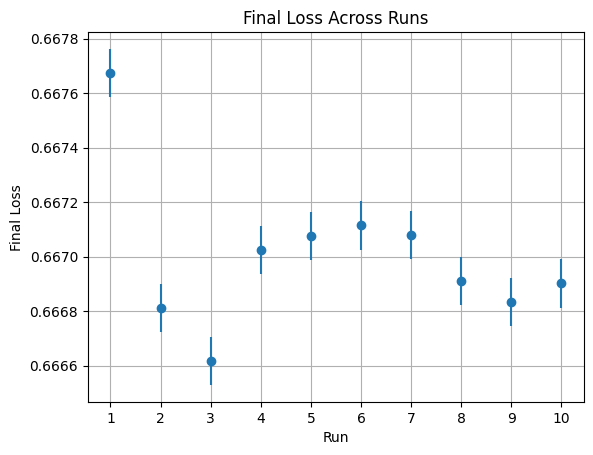

In [72]:
num_epochs = 11
losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for data in dataset:
        target, context = data['target'], data['context']
        labels = data['label'].float()
        model.zero_grad()
        logits = model(target, context)
        reg_loss = model.get_regularization_loss()
        loss = loss_function(logits, labels) + reg_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * target.size(0)
    avg_loss = total_loss / len(dataset.dataset)
    print(f"Epoch {epoch}: Loss = {avg_loss}")
    losses.append(avg_loss)

def train_and_evaluate(model, dataset, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
    loss_function = nn.BCEWithLogitsLoss()
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data in dataset:
            target, context = data['target'], data['context']
            labels = data['label'].float()
            model.zero_grad()
            logits = model(target, context)
            reg_loss = model.get_regularization_loss()
            loss = loss_function(logits, labels) + reg_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * target.size(0)
        avg_loss = total_loss / len(dataset.dataset)
        print(f"Epoch {epoch}: Loss = {avg_loss}")
        losses.append(avg_loss)
    return losses[-1]

num_runs = 10
final_losses = []

for _ in range(num_runs):
    model = SkipGramModel(vocabulary_size, embedding_dim)
    final_loss = train_and_evaluate(model, dataset, num_epochs)
    final_losses.append(final_loss)

loss_mean = np.mean(final_losses)
loss_std_error = np.std(final_losses, ddof=1) / np.sqrt(len(final_losses))

results_df = pd.DataFrame({
    "Run": range(1, num_runs + 1),
    "Final Loss": final_losses
})
results_df.loc['Mean'] = [np.nan, loss_mean]
results_df.loc['Std. Error'] = [np.nan, loss_std_error]

print(results_df)

plt.errorbar(range(1, num_runs + 1), final_losses, yerr=[loss_std_error]*num_runs, fmt='o')
plt.title("Final Loss Across Runs")
plt.xlabel("Run")
plt.ylabel("Final Loss")
plt.xticks(range(1, num_runs + 1))
plt.grid(True)
plt.show()

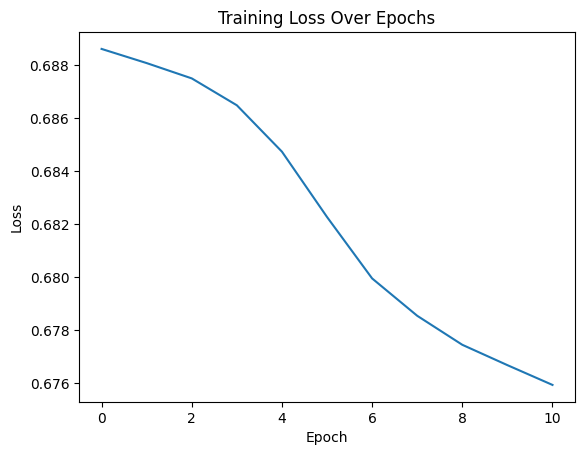

In [73]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training Loss Over Epochs")
plt.show()

In [74]:
movie_embeddings = model.embed_item.weight.detach().numpy()
print("Embeddings shape:", movie_embeddings.shape)

Embeddings shape: (517, 50)


In [75]:
query_movies = [
    "Toy Story (1995)",
    "GoldenEye (1995)",
    "Four Rooms (1995)",
]

In [76]:
query_embeddings = []

for movie_title in query_movies:
    movie_id = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movie_id]
    movie_embedding = movie_embeddings[token_id]
    query_embeddings.append(movie_embedding)

query_embeddings = np.array(query_embeddings)

In [77]:
def normalize_embeddings_torch(embeddings):
    norms = torch.norm(embeddings, p=2, dim=1, keepdim=True)
    return embeddings / norms

query_embeddings_tensor = torch.tensor(query_embeddings).float()
movie_embeddings_tensor = torch.tensor(movie_embeddings).float()

normalized_query_embeddings_torch = normalize_embeddings_torch(query_embeddings_tensor)
normalized_movie_embeddings_torch = normalize_embeddings_torch(movie_embeddings_tensor)

similarities_torch = torch.matmul(normalized_query_embeddings_torch, normalized_movie_embeddings_torch.T)

k = 5
_, indices_torch = torch.topk(similarities_torch, k=k)

indices_list = indices_torch.numpy().tolist()

In [78]:
top_k = 5

for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices_list[idx]
    for token in similar_tokens:
        if token == 0:
          continue
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()


Toy Story (1995)
----------------
- Toy Story (1995)
- Titanic (1997)
- Mary Poppins (1964)
- Lion King, The (1994)

GoldenEye (1995)
----------------
- GoldenEye (1995)
- Jean de Florette (1986)
- Bed of Roses (1996)
- Paris, Texas (1984)

Four Rooms (1995)
-----------------
- Four Rooms (1995)
- Crow, The (1994)
- Jackie Chan's First Strike (1996)
- Star Trek: Generations (1994)

